In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.naive_bayes
import sklearn.ensemble as ske
import sklearn.neighbors
import sklearn.pipeline
import sklearn.linear_model
import joblib
from sklearn import preprocessing
from sklearn import tree, linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
import sys
import sqlite3
import importlib
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics

In [2]:
!pip install shap

In [3]:
df_wild = pd.read_pickle('/kaggle/input/wild-pickle/wild.pickle')

In [4]:
MAX_LENGTH = int(1e6)
prev_size = len(df_wild)
df_wild = df_wild[df_wild['generic_fileSize'] <= MAX_LENGTH]
print("considering samples with size less than {} bytes, {} ----> {}".format(MAX_LENGTH, prev_size, len(df_wild)))

considering samples with size less than 1000000 bytes, 50724 ----> 37354


In [5]:
df_wild.head()

,sample_sha1,benign,malicious,packed,unpacked_sample_sha1,unpacked_sample_id,packer_name,imp_setupremovefilelogentrya,imp_vardeccmp,imp_setdlgitemint,...,opcode_xor sub mov,opcode_xor sub mov add,opcode_xor test,opcode_xor test je,opcode_xor xor,opcode_xor xor mov,opcode_xor xor pop,opcode_xor xor pop mov,opcode_xor xor xor,opcode_xor xor xor pop
1,a2aac23e17be570c647fd22080e05b0e58449565,True,False,True,-1,-1,none,False,False,False,...,0.000022,0.0,0.000088,0.000084,0.000070,0.000066,0.000028,0.0,0.000053,0.0
2,c3aa534bbd20f3a3dd8e7a457f625291af9d0fe4,False,True,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000000,0.000000,0.000309,0.000000,0.000000,0.0,0.000331,0.0
10,15cb9eab6b0f0ccd718a9235f07046dff100789f,False,True,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
12,8792cf08950abada1572b47948e86c9fce26c01a,True,False,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
13,353a955ae9919f7b639d74394e3c1149f0189362,True,False,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000204,0.000190,0.000066,0.000091,0.000000,0.0,0.000000,0.0


In [6]:
print(df_wild.shape)

(37354, 56555)


In [7]:
df_wild = df_wild.loc[:, (df_wild != 0).any(axis=0)]
df_wild.head()

,sample_sha1,benign,malicious,packed,unpacked_sample_sha1,unpacked_sample_id,packer_name,imp_setupremovefilelogentrya,imp_vardeccmp,imp_setdlgitemint,...,opcode_xor sub mov,opcode_xor sub mov add,opcode_xor test,opcode_xor test je,opcode_xor xor,opcode_xor xor mov,opcode_xor xor pop,opcode_xor xor pop mov,opcode_xor xor xor,opcode_xor xor xor pop
1,a2aac23e17be570c647fd22080e05b0e58449565,True,False,True,-1,-1,none,False,False,False,...,0.000022,0.0,0.000088,0.000084,0.000070,0.000066,0.000028,0.0,0.000053,0.0
2,c3aa534bbd20f3a3dd8e7a457f625291af9d0fe4,False,True,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000000,0.000000,0.000309,0.000000,0.000000,0.0,0.000331,0.0
10,15cb9eab6b0f0ccd718a9235f07046dff100789f,False,True,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
12,8792cf08950abada1572b47948e86c9fce26c01a,True,False,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
13,353a955ae9919f7b639d74394e3c1149f0189362,True,False,True,-1,-1,none,False,False,False,...,0.000000,0.0,0.000204,0.000190,0.000066,0.000091,0.000000,0.0,0.000000,0.0


In [8]:
df = df_wild.sample(n=12000, random_state=102)

In [9]:
df = df.drop(['sample_sha1','benign','unpacked_sample_sha1','unpacked_sample_id'], axis=1)
df = df.drop(['benign_vt','malicious_vt'], axis=1)

In [10]:
string_columns = df.select_dtypes(include=['object']).columns
df = df.drop(string_columns, axis=1)

In [11]:
df.head()

,malicious,packed,imp_setupremovefilelogentrya,imp_vardeccmp,imp_setdlgitemint,imp_?append@?$basic_string@du?$char_traits@d@std@@v?$allocator@d@2@@std@@qaeaav12@abv12@ii@z,imp_glstencilop,imp_comparelinkinforeferents,imp__setmbcp,imp_?strcmp@wstring@@qbejpbv1@@z,...,opcode_xor sub mov,opcode_xor sub mov add,opcode_xor test,opcode_xor test je,opcode_xor xor,opcode_xor xor mov,opcode_xor xor pop,opcode_xor xor pop mov,opcode_xor xor xor,opcode_xor xor xor pop
32148,False,True,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000187,0.000198,0.0,0.0,0.0,0.0,0.0,0.0
210953,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50313,False,True,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
200288,True,True,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
49579,True,True,False,False,False,False,False,False,False,False,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print(df.shape)

(12000, 43963)


In [13]:
df_10000 = df.sample(n=10000, random_state=102)
df_2000 = df.drop(df_10000.index)

In [14]:
data = df_10000.sample(n=5000, random_state=102)

In [15]:
#Kiểm tra số lượng mẫu
UB = data[(data['malicious'] == False) & (data['packed'] == False)].shape[0]
PM = data[(data['malicious'] == True) & (data['packed'] == True)].shape[0]
PB = data[(data['malicious'] == False) & (data['packed'] == True)].shape[0]
print('Unpacked Benign: %i samples' % UB)
print('Packed Malware: %i samples' % PM)
print('Packed Benign: %i samples' % PB)
print('Total TRAIN set: %i samples'% (UB+PM+PB))

Unpacked Benign: 327 samples
Packed Malware: 3807 samples
Packed Benign: 866 samples
Total TRAIN set: 5000 samples


In [16]:
#Chia tỉ lệ 50 - 50
data_PM = data[(data['malicious'] == True) & (data['packed'] == True)].sample(n=(PM-(UB+PB)), random_state=102)
data = data.drop(data_PM.index)

In [17]:
#Số lượng tập train
UB = data[(data['malicious'] == False) & (data['packed'] == False)].shape[0]
PM = data[(data['malicious'] == True) & (data['packed'] == True)].shape[0]
PB = data[(data['malicious'] == False) & (data['packed'] == True)].shape[0]
print('Unpacked Benign: %i samples' % UB)
print('Packed Malware: %i samples' % PM)
print('Packed Benign: %i samples' % PB)
print('Total TRAIN set: %i samples'% (UB+PM+PB))

Unpacked Benign: 327 samples
Packed Malware: 1193 samples
Packed Benign: 866 samples
Total TRAIN set: 2386 samples


In [18]:
#Xử lý tập train
y = data['malicious'].values
data = data.drop(['malicious','packed'], axis=1)

In [19]:
UB = df_2000[(df_2000['malicious'] == False) & (df_2000['packed'] == False)].shape[0]
PM = df_2000[(df_2000['malicious'] == True) & (df_2000['packed'] == True)].shape[0]
PB = df_2000[(df_2000['malicious'] == False) & (df_2000['packed'] == True)].shape[0]

df_2000_PM = df_2000[(df_2000['malicious'] == True) & (df_2000['packed'] == True)].sample(n=(PM-(UB+PB)), random_state=102)
df_2000 = df_2000.drop(df_2000_PM.index)

UB = df_2000[(df_2000['malicious'] == False) & (df_2000['packed'] == False)].shape[0]
PM = df_2000[(df_2000['malicious'] == True) & (df_2000['packed'] == True)].shape[0]
PB = df_2000[(df_2000['malicious'] == False) & (df_2000['packed'] == True)].shape[0]

print('Unpacked Benign: %i samples' % UB)
print('Packed Malware: %i samples' % PM)
print('Packed Benign: %i samples' % PB)
print('Total TEST set: %i samples'% (UB+PM+PB))

Unpacked Benign: 142 samples
Packed Malware: 501 samples
Packed Benign: 359 samples
Total TEST set: 1002 samples


In [20]:
print('Researching important feature based on %i total features' % data.shape[1])
fsel = ske.ExtraTreesClassifier().fit(data, y)

Researching important feature based on 43961 total features


In [21]:
# model = SelectFromModel(fsel, prefit=True)

X_train = data
X_test = df_2000.drop(['malicious','packed'], axis=1)

data = data.loc[:, (data != 0).any(axis=0)]
x_train = data
X_test = df_2000.drop(['malicious','packed'], axis=1)
y_train = y
y_test = df_2000['malicious'].values

**RANDOM FOREST**

In [22]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

random_forest = RandomForestClassifier(n_estimators=100, random_state=17)
random_forest.fit(X_train, y_train)
random_forest_preds = random_forest.predict(X_test)
print('The accuracy of the Random Forests model is :\t',metrics.accuracy_score(random_forest_preds,y_test))

The accuracy of the Random Forests model is :	 0.936127744510978


In [23]:
feature_scores_rf = pd.Series(random_forest.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores_rf

ngram_b'\x01\n\x02\x82\x01\x01'      0.012046
ngram_b'\x86H\x86\xf7\r\x01'         0.008525
ngram_b'0\x18\x06\t*\x86'            0.007833
ngram_b'H\x86\xf7\r\x01\x01'         0.007618
ngram_b'\xf7\r\x01\t\x041'           0.007589
                                       ...   
pesection_7_characteristics_bit20    0.000000
pesection_7_characteristics_bit21    0.000000
pesection_7_characteristics_bit22    0.000000
pesection_7_characteristics_bit25    0.000000
opcode_xor xor xor pop               0.000000
Length: 43961, dtype: float64

In [24]:
selected_features_rf = feature_scores_rf[feature_scores_rf != 0].index
X_train_rf = X_train[selected_features_rf]
X_test_rf = X_test[selected_features_rf]

In [25]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

random_forest_selected = RandomForestClassifier(n_estimators=100, random_state=17)
random_forest_selected.fit(X_train_rf, y_train)
random_forest_preds_selected = random_forest_selected.predict(X_test_rf)
print('The accuracy of the Random Forests model is :\t',metrics.accuracy_score(random_forest_preds_selected,y_test))

The accuracy of the Random Forests model is :	 0.9311377245508982


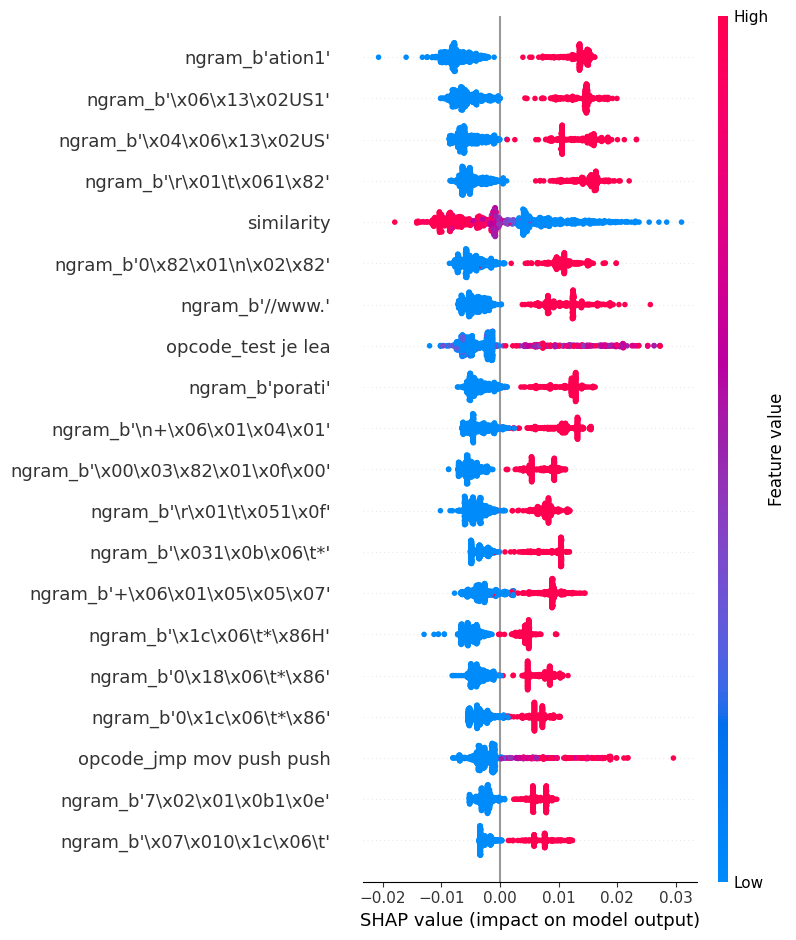

In [26]:
import shap
import matplotlib.pyplot as plt
shap.initjs()
explainer_rf = shap.TreeExplainer(random_forest_selected)

shap_values_rf = explainer_rf.shap_values(X_test_rf)
shap.summary_plot(shap_values_rf[0], X_test_rf)

In [27]:
feature_names_rf = X_train_rf.columns

rf_result_rf_X = pd.DataFrame(shap_values_rf[1], columns = feature_names_rf)

vals = np.abs(rf_result_rf_X.values).mean(0)

shap_importance_rf = pd.DataFrame(list(zip(feature_names_rf, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance_rf.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance_rf
shap_importance_rf.to_csv('rf_importance.csv')

**Decision Tree**

In [28]:
dt = tree.DecisionTreeClassifier(splitter='best', criterion='gini', random_state=17)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
print('The accuracy of the Decision Tree model is :\t',metrics.accuracy_score(dt_preds,y_test))

The accuracy of the Decision Tree model is :	 0.9121756487025948


In [29]:
feature_scores_dt = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores_dt

ngram_b'\x05\x05\x07\x03\x080'              0.415749
opcode_test je lea                          0.154189
pesectionProcessed_sectionsMaxEntropy       0.050654
similarity                                  0.046008
opcode_add mov add add                      0.038039
                                              ...   
afw.dll                                     0.000000
bcs.dll                                     0.000000
oodb61.dll                                  0.000000
api-ms-win-core-libraryloader-l1-2-0.dll    0.000000
opcode_xor xor xor pop                      0.000000
Length: 43961, dtype: float64

In [30]:
selected_features_dt = feature_scores_dt[feature_scores_dt != 0].index
X_train_dt = X_train[selected_features_dt]
X_test_dt = X_test[selected_features_dt]

In [31]:
dt_selected = tree.DecisionTreeClassifier(splitter='best', criterion='gini', random_state=17)
dt_selected.fit(X_train_dt, y_train)
dt_preds_selected = dt_selected.predict(X_test_dt)
print('The accuracy of the Random Forests model is :\t',metrics.accuracy_score(dt_preds_selected,y_test))

The accuracy of the Random Forests model is :	 0.9131736526946108


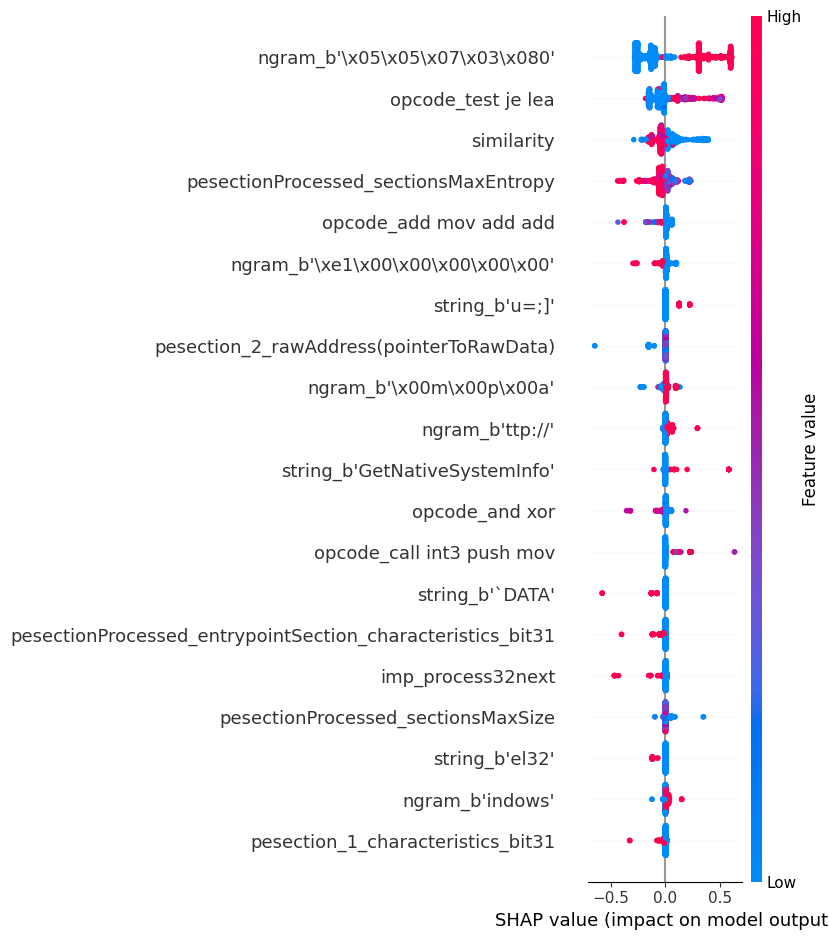

In [32]:
shap.initjs()
explainer_dt = shap.TreeExplainer(dt_selected)

shap_values_dt = explainer_dt.shap_values(X_test_dt)
shap.summary_plot(shap_values_dt[0], X_test_dt)                               

In [33]:
feature_names_dt = X_train_dt.columns

rf_result_dt_X = pd.DataFrame(shap_values_dt[1], columns = feature_names_dt)

vals = np.abs(rf_result_dt_X.values).mean(0)

shap_importance_dt = pd.DataFrame(list(zip(feature_names_dt, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance_dt.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance_dt
shap_importance_dt.to_csv('dt_importance.csv')

**GradientBoosting**

In [34]:
boost = ske.GradientBoostingClassifier(n_estimators=100)
boost.fit(X_train, y_train)
boost_preds = boost.predict(X_test)
print('The accuracy of the Gradient Boosting model is :\t',metrics.accuracy_score(boost_preds,y_test))

The accuracy of the Gradient Boosting model is :	 0.9491017964071856


In [35]:
feature_scores_boost = pd.Series(boost.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores_boost

ngram_b'\x05\x05\x07\x03\x080'      0.196272
opcode_test je lea                  0.092811
ngram_b'://www'                     0.092582
similarity                          0.062503
ngram_b'osoft.'                     0.043777
                                      ...   
imp_windowscreatestringreference    0.000000
imp_roinitialize                    0.000000
imp_rouninitialize                  0.000000
imp_rogetactivationfactory          0.000000
opcode_xor xor xor pop              0.000000
Length: 43961, dtype: float64

In [36]:
selected_features_boost = feature_scores_boost[feature_scores_boost != 0].index
X_train_boost = X_train[selected_features_boost]
X_test_boost = X_test[selected_features_boost]

In [37]:
boost_selected = ske.GradientBoostingClassifier(n_estimators=100)
boost_selected.fit(X_train_boost, y_train)
boost_preds_selected = boost_selected.predict(X_test_boost)
print('The accuracy of the Gradient Boosting model is :\t',metrics.accuracy_score(boost_preds_selected,y_test))

The accuracy of the Gradient Boosting model is :	 0.9510978043912176


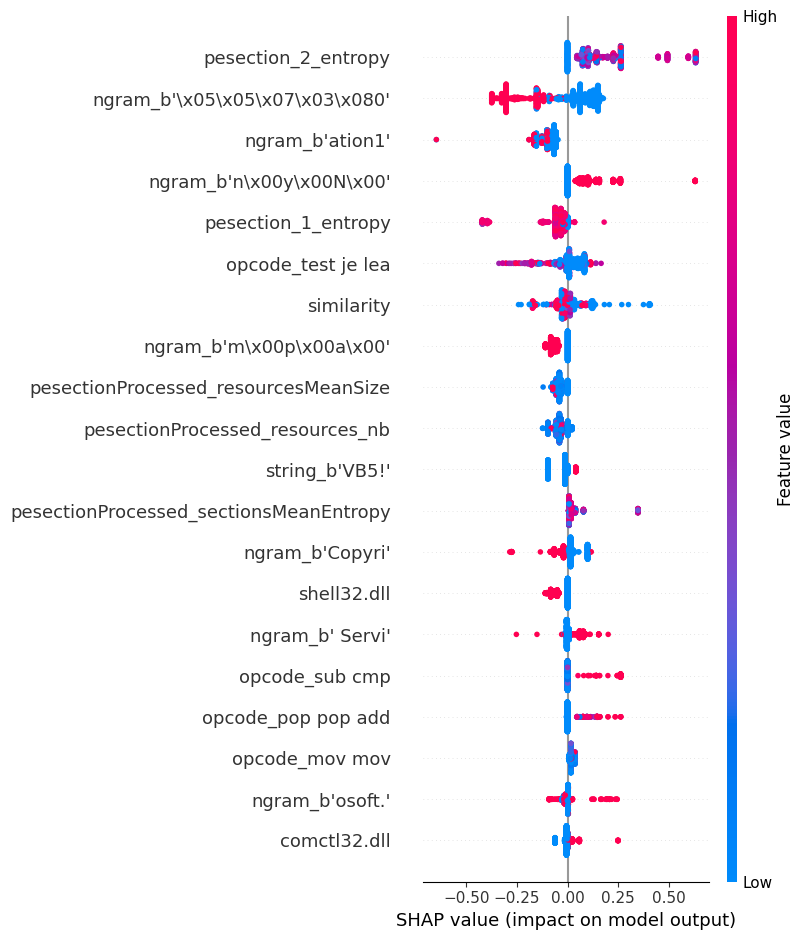

In [38]:
shap.initjs()
explainer_boost = shap.TreeExplainer(boost_selected)

shap_values_boost = explainer_dt.shap_values(X_test_boost)
shap.summary_plot(shap_values_boost[0], X_test_boost)                               

In [39]:
feature_names_boost = X_train_boost.columns

rf_result_boost_X = pd.DataFrame(shap_values_boost[1], columns = feature_names_boost)

vals = np.abs(rf_result_boost_X.values).mean(0)

shap_importance_boost = pd.DataFrame(list(zip(feature_names_boost, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance_boost.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance_boost
shap_importance_boost.to_csv('boost_importance.csv')